# Part III: Diverse Sequential Group Recommendation (25 points)

**Students:** Oskari Perikangas, Xiaosi Huang  
**Date:** November 16, 2025


### New Challenges

Diversity in sequential group recommendations prevents bias reinforcement from repeated similar content. Users risk only seeing content matching past behavior, limiting exposure to new movies.

**Solution:** Promote diversity while ensuring content remains relevant and engaging for all group members.

---

### Step 1: Design method of DiGSFO (7 points)

**Method:** Diversity-Guided Selection with Fairness Optimization (DiGSFO)  
**Source:** Emilia Lenzi's Lecture, pages 30-32

**Notation:**
- G = group of users
- i = item (movie) or candidate list
- r = round number
- δ = distance threshold for diversity filtering
- s = number of top items per user (candidate pool size)
- t = number of candidate lists to evaluate
- k = final recommendation list size

**Round 1:**

First round has no recommendation history, so diversity cannot be calculated.  
Use Average aggregation on individual items:
- Generate top-s items for each user
- Merge into candidate pool G_l
- Score each item: group_score(G, i, r) = AvgScore(G, i, r)
- Select top-k items as recommendations

**Round 2 onwards:**

Recommendation history is available. Apply DiGSFO process:

1. **Generate candidate lists:**  
   - Get top-s items for each user, merge into G_l
   - Sort G_l by scores
   - Generate t candidate lists using sliding window: [items 1-k], [items 2-(k+1)], ..., [items t-(t+k-1)]

2. **Filter by diversity:**  
   For each candidate list, calculate distance to all historical recommendations.  
   Remove lists with distance < δ (too similar to history).

3. **Score by fairness:**  
   For remaining lists, calculate fairness score:  
   group_score(G, list, r) = F(G, list) where F is satisfaction disparity

4. **Select best list:**  
   Choose the list with lowest fairness score (most fair) as final recommendations.

### Key Formulas

**ADAPT Fairness** (Emilia Lenzi's Lecture, page 21):

$$F(G,L_{G,R}) = \max_u satO(u,L_{G,R}) - \min_u satO(u,L_{G,R})$$

Lower F value means better fairness (smaller satisfaction gap between users)

**Diversity in ADAPT** (Emilia Lenzi's Lecture, page 22):

$$Div(L_{G,r}, L_{G,r-1}) = \sqrt{\sum_{n=1}^{N}(emb(L_{G,r})^{(n)} - emb(L_{G,r-1})^{(n)})^2}$$

This measures the distance between current and previous recommendation lists.

**Embedding:**  
Each movie is represented as a genre vector (20 dimensions).  
MovieLens 100K has 20 genres: Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western, (no genres listed)

List embedding = average of all movie genre vectors in the list

### Why DiGSFO Works

- Sliding window candidate generation explores diverse list combinations
- Distance threshold δ prevents recommending lists with similar genres to history
- Fairness metric ensures balanced satisfaction across all users in the group
- List-level optimization (not item-level) maintains coherence in recommendations

# Step 2: Implementation (7 points)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load MovieLens dataset
ratings_df = pd.read_csv("../data/ml-latest-small/ratings.csv")

# Rename columns
ratings_df.rename(columns={'userId': 'user_id', 'movieId': 'item_id'}, inplace=True)

# Create user ratings dictionary
user_ratings_dict = {}
for user_id in ratings_df['user_id'].unique():
    user_ratings_dict[user_id] = {}
    user_data = ratings_df[ratings_df['user_id'] == user_id]
    for _, row in user_data.iterrows():
        user_ratings_dict[user_id][row['item_id']] = row['rating']

print(f"Loaded: {len(ratings_df)} ratings")
print(f"Users: {len(user_ratings_dict)}")
print(f"Movies: {ratings_df['item_id'].nunique()}")

Loaded: 100836 ratings
Users: 610
Movies: 9724


In [2]:
# Load movies with genres
movies_df = pd.read_csv("../data/ml-latest-small/movies.csv")
movies_df.rename(columns={'movieId': 'item_id'}, inplace=True)

# Extract all unique genres
all_genres = set()
for genres_str in movies_df['genres'].dropna():
    for genre in genres_str.split('|'):
        all_genres.add(genre)

all_genres = sorted(list(all_genres))
genre_to_idx = {genre: idx for idx, genre in enumerate(all_genres)}

print(f"Total movies: {len(movies_df)}")
print(f"Total genres: {len(all_genres)}")
print(f"Genres: {all_genres}")

Total movies: 9742
Total genres: 20
Genres: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [3]:
def get_movie_embedding(item_id, movies_df, genre_to_idx):
    """Convert movie to genre vector (20 dimensions)"""
    movie_row = movies_df[movies_df['item_id'] == item_id]
    
    if len(movie_row) == 0:
        return np.zeros(len(genre_to_idx))
    
    genres_str = movie_row.iloc[0]['genres']
    embedding = np.zeros(len(genre_to_idx))
    
    if pd.notna(genres_str):
        for genre in genres_str.split('|'):
            if genre in genre_to_idx:
                embedding[genre_to_idx[genre]] = 1
    
    return embedding

def get_list_embedding(rec_list, movies_df, genre_to_idx):
    """Get average embedding for a list of movies"""
    if not rec_list:
        return np.zeros(len(genre_to_idx))
    
    embeddings = [get_movie_embedding(item_id, movies_df, genre_to_idx) 
                  for item_id in rec_list]
    return np.mean(embeddings, axis=0)

def calculate_diversity(list1, list2, movies_df, genre_to_idx):
    """Calculate Euclidean distance between two recommendation lists"""
    emb1 = get_list_embedding(list1, movies_df, genre_to_idx)
    emb2 = get_list_embedding(list2, movies_df, genre_to_idx)
    return np.linalg.norm(emb1 - emb2)

print("Embedding functions loaded")

Embedding functions loaded


In [4]:
class GroupState:
    """Manages group recommendation state"""
    
    def __init__(self, group_users, user_ratings_dict):
        self.group_users = group_users
        self.user_ratings_dict = user_ratings_dict
        self.sat_history = {user: [] for user in group_users}
        self.recommendation_history = []
        self.current_round = 0
    
    def update_round(self, recommendations, satisfactions):
        """Update state after each round"""
        self.current_round += 1
        self.recommendation_history.append(recommendations)
        for user in self.group_users:
            if user in satisfactions:
                self.sat_history[user].append(satisfactions[user])
    
    def get_overall_satisfaction(self):
        """Calculate average satisfaction across all rounds"""
        satO = {}
        for user in self.group_users:
            if self.sat_history[user]:
                satO[user] = np.mean(self.sat_history[user])
            else:
                satO[user] = 0.0
        return satO

print("GroupState class loaded")

GroupState class loaded


In [5]:
def pearson_similarity(ratings1, ratings2, min_common=3):
    """Calculate Pearson correlation between two users"""
    common = set(ratings1.keys()) & set(ratings2.keys())
    if len(common) < min_common:
        return 0.0
    
    r1 = [ratings1[i] for i in common]
    r2 = [ratings2[i] for i in common]
    
    m1, m2 = np.mean(r1), np.mean(r2)
    num = sum((a - m1) * (b - m2) for a, b in zip(r1, r2))
    d1 = np.sqrt(sum((a - m1) ** 2 for a in r1))
    d2 = np.sqrt(sum((b - m2) ** 2 for b in r2))
    
    return num / (d1 * d2) if d1 > 0 and d2 > 0 else 0.0

def predict_rating(user_id, item_id, ratings_df, user_ratings_dict, k=15):
    """Predict rating using collaborative filtering"""
    target_ratings = user_ratings_dict[user_id]
    target_mean = np.mean(list(target_ratings.values()))
    
    item_ratings = ratings_df[ratings_df['item_id'] == item_id]
    if len(item_ratings) == 0:
        return target_mean
    
    similarities = []
    for _, row in item_ratings.iterrows():
        neighbor_id = row['user_id']
        if neighbor_id != user_id and neighbor_id in user_ratings_dict:
            sim = pearson_similarity(target_ratings, user_ratings_dict[neighbor_id])
            if sim > 0:
                similarities.append((sim, neighbor_id, row['rating']))
    
    if similarities:
        similarities.sort(reverse=True)
        top_k = similarities[:k]
        
        weighted_sum = sum(sim * (rating - np.mean(list(user_ratings_dict[nid].values()))) 
                          for sim, nid, rating in top_k)
        sim_sum = sum(abs(sim) for sim, _, _ in top_k)
        
        if sim_sum > 0:
            predicted = target_mean + (weighted_sum / sim_sum)
            return max(0.5, min(5.0, predicted))
    
    return max(0.5, min(5.0, item_ratings['rating'].mean()))

print("Collaborative filtering functions loaded")

Collaborative filtering functions loaded


In [6]:
class DiGSFO_Recommender:
    """DiGSFO: Diversity-Guided Selection with Fairness Optimization"""
    
    def __init__(self, group_users, ratings_df, user_ratings_dict, 
                 movies_df, genre_to_idx, delta=0.5, s=100, t=50, k=5):
        self.state = GroupState(group_users, user_ratings_dict)
        self.ratings_df = ratings_df
        self.user_ratings_dict = user_ratings_dict
        self.movies_df = movies_df
        self.genre_to_idx = genre_to_idx
        self.delta = delta
        self.s = s  # top items per user
        self.t = t  # number of candidate lists
        self.k = k  # final recommendation size
        self.popular_movies = self._get_popular_movies()
        self.used_movies = set()
    
    def _get_popular_movies(self, min_ratings=30):
        """Get movies with enough ratings"""
        movie_counts = self.ratings_df.groupby('item_id').size()
        return movie_counts[movie_counts >= min_ratings].index.tolist()
    
    def calculate_satisfaction(self, user_id, recommendations):
        """Calculate user satisfaction for a list of recommendations"""
        predictions = [predict_rating(user_id, item, self.ratings_df, 
                                     self.user_ratings_dict) 
                      for item in recommendations]
        if not predictions:
            return 0.0
        
        avg_rating = np.mean(predictions)
        satisfaction = (avg_rating - 0.5) / 4.5
        return max(0.0, min(1.0, satisfaction))
    
    def get_user_top_items(self, user_id, k_candidates=200):
        """Get top-s items for one user"""
        user_rated = set(self.ratings_df[self.ratings_df['user_id'] == user_id]['item_id'])
        candidates = [item for item in self.popular_movies 
                     if item not in user_rated and item not in self.used_movies]
        
        predictions = {}
        for item in candidates[:k_candidates]:
            predictions[item] = predict_rating(user_id, item, self.ratings_df, 
                                              self.user_ratings_dict)
        
        sorted_items = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
        return sorted_items[:self.s]

print("DiGSFO_Recommender: initialization and basic methods loaded")

DiGSFO_Recommender: initialization and basic methods loaded


In [7]:
def build_candidate_pool(self):
    """Build candidate pool G_l from all users' top-s items"""
    G_l = {}
    
    for user_id in self.state.group_users:
        user_top_items = self.get_user_top_items(user_id)
        for item, score in user_top_items:
            if item not in G_l:
                G_l[item] = []
            G_l[item].append(score)
    
    # Average score for each item across users
    G_l_scores = {}
    for item, scores in G_l.items():
        G_l_scores[item] = np.mean(scores)
    
    return G_l_scores

def generate_candidate_lists(self, G_l_scores):
    """Generate t candidate lists using sliding window"""
    sorted_items = sorted(G_l_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_item_ids = [item for item, score in sorted_items]
    
    candidate_lists = []
    for i in range(min(self.t, len(sorted_item_ids) - self.k + 1)):
        candidate_list = sorted_item_ids[i:i+self.k]
        candidate_lists.append(candidate_list)
    
    return candidate_lists

# Add methods to class
DiGSFO_Recommender.build_candidate_pool = build_candidate_pool
DiGSFO_Recommender.generate_candidate_lists = generate_candidate_lists

print("DiGSFO_Recommender: candidate generation methods loaded")

DiGSFO_Recommender: candidate generation methods loaded


In [8]:
def calculate_list_fairness(self, candidate_list):
    """Calculate weighted fairness considering historical satisfaction"""
    
    satO = self.state.get_overall_satisfaction()
    
    current_sats = {}
    for user_id in self.state.group_users:
        current_sats[user_id] = self.calculate_satisfaction(user_id, candidate_list)
    
    if not satO or all(s == 0 for s in satO.values()):
        return max(current_sats.values()) - min(current_sats.values())
    
    min_sat = min(satO.values())
    max_sat = max(satO.values())
    
    weights = {}
    if max_sat > min_sat:
        for user_id in self.state.group_users:
            weights[user_id] = 1.0 - (satO[user_id] - min_sat) / (max_sat - min_sat)
    else:
        weights = {uid: 1.0 for uid in self.state.group_users}
    
    total_w = sum(weights.values())
    weights = {uid: w/total_w for uid, w in weights.items()}
    
    weighted_fairness = 0
    for user_id in self.state.group_users:
        weighted_fairness += weights[user_id] * (1 - current_sats[user_id])
    
    return weighted_fairness

def calculate_list_distance_to_history(self, candidate_list):
    """Calculate minimum distance from candidate list to all historical lists"""
    if not self.state.recommendation_history:
        return float('inf')
    
    candidate_emb = get_list_embedding(candidate_list, self.movies_df, self.genre_to_idx)
    
    min_dist = float('inf')
    for past_list in self.state.recommendation_history:
        past_emb = get_list_embedding(past_list, self.movies_df, self.genre_to_idx)
        dist = np.linalg.norm(candidate_emb - past_emb)
        min_dist = min(min_dist, dist)
    
    return min_dist

DiGSFO_Recommender.calculate_list_fairness = calculate_list_fairness
DiGSFO_Recommender.calculate_list_distance_to_history = calculate_list_distance_to_history

print("DiGSFO_Recommender: weighted fairness and diversity methods loaded")

DiGSFO_Recommender: weighted fairness and diversity methods loaded


In [9]:
def recommend_round(self):
    """One round of DiGSFO recommendation"""
    
    # Build candidate pool
    G_l_scores = self.build_candidate_pool()
    
    if not G_l_scores:
        return [], {}
    
    # Round 1: Use Average aggregation on items
    if self.state.current_round == 0:
        sorted_items = sorted(G_l_scores.items(), key=lambda x: x[1], reverse=True)
        recommendations = [item for item, score in sorted_items[:self.k]]
    
    # Round 2+: DiGSFO with candidate lists
    else:
        candidate_lists = self.generate_candidate_lists(G_l_scores)
        
        # Filter by diversity and score by fairness
        valid_lists = []
        for candidate_list in candidate_lists:
            dist = self.calculate_list_distance_to_history(candidate_list)
            if dist >= self.delta:
                fairness = self.calculate_list_fairness(candidate_list)
                valid_lists.append((candidate_list, fairness))
        
        # If no valid lists, use first candidate
        if not valid_lists:
            recommendations = candidate_lists[0] if candidate_lists else []
        else:
            # Select list with lowest fairness (most fair)
            valid_lists.sort(key=lambda x: x[1])
            recommendations = valid_lists[0][0]
    
    # Mark movies as used
    self.used_movies.update(recommendations)
    
    # Calculate satisfactions
    satisfactions = {}
    for user_id in self.state.group_users:
        satisfactions[user_id] = self.calculate_satisfaction(user_id, recommendations)
    
    self.state.update_round(recommendations, satisfactions)
    return recommendations, satisfactions

# Add method to class
DiGSFO_Recommender.recommend_round = recommend_round

print("DiGSFO_Recommender: recommendation method loaded")

DiGSFO_Recommender: recommendation method loaded


In [10]:
def run(self, num_rounds=10, verbose=True):
    """Run multiple rounds of DiGSFO recommendations"""
    if verbose:
        print(f"\n{'='*70}")
        print(f"DiGSFO (delta={self.delta}, s={self.s}, t={self.t}, k={self.k})")
        print(f"Group: {self.state.group_users}")
        print(f"{'='*70}")
    
    all_recs = []
    diversity_scores = []
    
    for r in range(num_rounds):
        recs, sats = self.recommend_round()
        all_recs.append(recs)
        
        # Calculate diversity with previous round
        if r > 0:
            div = calculate_diversity(recs, all_recs[r-1], 
                                     self.movies_df, self.genre_to_idx)
            diversity_scores.append(div)
        
        if verbose:
            sat_str = ', '.join([f'{uid}:{sat:.2f}' for uid, sat in sats.items()])
            div_str = f", Div={diversity_scores[-1]:.3f}" if r > 0 else ""
            print(f"Round {r+1:2d}: Sats=[{sat_str}]{div_str}")
    
    # Calculate final metrics
    satO = self.state.get_overall_satisfaction()
    groupSat = np.mean(list(satO.values()))
    groupDis = max(satO.values()) - min(satO.values())
    avgDiv = np.mean(diversity_scores) if diversity_scores else 0.0
    
    if verbose:
        print(f"{'-'*70}")
        satO_str = ', '.join([f'{uid}:{s:.2f}' for uid, s in satO.items()])
        print(f"Final: SatO=[{satO_str}]")
        print(f"       GroupSat={groupSat:.3f}, GroupDis={groupDis:.3f}, AvgDiv={avgDiv:.3f}")
    
    return {
        'recommendations': all_recs,
        'group_satisfaction': groupSat,
        'group_disagreement': groupDis,
        'avg_diversity': avgDiv,
        'diversity_scores': diversity_scores,
        'user_satisfactions': satO
    }

# Add method to class
DiGSFO_Recommender.run = run

print("DiGSFO_Recommender: evaluation and run method loaded")

DiGSFO_Recommender: evaluation and run method loaded


In [11]:
# Test group from Part I and Part II
test_group = [1, 414, 599]

# Run DiGSFO with delta=0.5
rec = DiGSFO_Recommender(
    group_users=test_group,
    ratings_df=ratings_df,
    user_ratings_dict=user_ratings_dict,
    movies_df=movies_df,
    genre_to_idx=genre_to_idx,
    delta=0.5,
    s=100,
    t=50,
    k=5
)

result = rec.run(num_rounds=10, verbose=True)


DiGSFO (delta=0.5, s=100, t=50, k=5)
Group: [1, 414, 599]
Round  1: Sats=[1:1.00, 414:0.84, 599:0.70]
Round  2: Sats=[1:1.00, 414:0.84, 599:0.67], Div=0.849
Round  3: Sats=[1:1.00, 414:0.82, 599:0.67], Div=0.748
Round  4: Sats=[1:0.98, 414:0.81, 599:0.64], Div=0.800
Round  5: Sats=[1:0.96, 414:0.78, 599:0.63], Div=0.600
Round  6: Sats=[1:0.99, 414:0.79, 599:0.61], Div=0.775
Round  7: Sats=[1:0.95, 414:0.77, 599:0.62], Div=0.959
Round  8: Sats=[1:1.00, 414:0.81, 599:0.62], Div=0.663
Round  9: Sats=[1:0.92, 414:0.77, 599:0.61], Div=0.917
Round 10: Sats=[1:0.96, 414:0.79, 599:0.62], Div=0.894
----------------------------------------------------------------------
Final: SatO=[1:0.98, 414:0.80, 599:0.64]
       GroupSat=0.806, GroupDis=0.337, AvgDiv=0.801


In [12]:
# Re-test with weighted fairness
deltas = [0.0, 0.3, 0.5, 0.8]
results_weighted = {}

print("\n" + "="*70)
print("Testing different delta values (with weighted fairness)")
print("="*70)

for delta in deltas:
    rec = DiGSFO_Recommender(
        group_users=test_group,
        ratings_df=ratings_df,
        user_ratings_dict=user_ratings_dict,
        movies_df=movies_df,
        genre_to_idx=genre_to_idx,
        delta=delta,
        s=100,
        t=50,
        k=5
    )
    
    result = rec.run(num_rounds=10, verbose=False)
    results_weighted[delta] = result
    
    print(f"\nDelta={delta}: GroupSat={result['group_satisfaction']:.3f}, "
          f"GroupDis={result['group_disagreement']:.3f}, "
          f"AvgDiv={result['avg_diversity']:.3f}")

print("\n" + "="*70)
print("Summary (Weighted Fairness)")
print("="*70)
print(f"{'Delta':<10} {'GroupSat':<12} {'GroupDis':<12} {'AvgDiv':<12}")
print("-"*70)
for delta in deltas:
    r = results_weighted[delta]
    print(f"{delta:<10.1f} {r['group_satisfaction']:<12.3f} "
          f"{r['group_disagreement']:<12.3f} {r['avg_diversity']:<12.3f}")


Testing different delta values (with weighted fairness)

Delta=0.0: GroupSat=0.806, GroupDis=0.337, AvgDiv=0.785

Delta=0.3: GroupSat=0.806, GroupDis=0.337, AvgDiv=0.785

Delta=0.5: GroupSat=0.806, GroupDis=0.337, AvgDiv=0.801

Delta=0.8: GroupSat=0.796, GroupDis=0.344, AvgDiv=0.960

Summary (Weighted Fairness)
Delta      GroupSat     GroupDis     AvgDiv      
----------------------------------------------------------------------
0.0        0.806        0.337        0.785       
0.3        0.806        0.337        0.785       
0.5        0.806        0.337        0.801       
0.8        0.796        0.344        0.960       


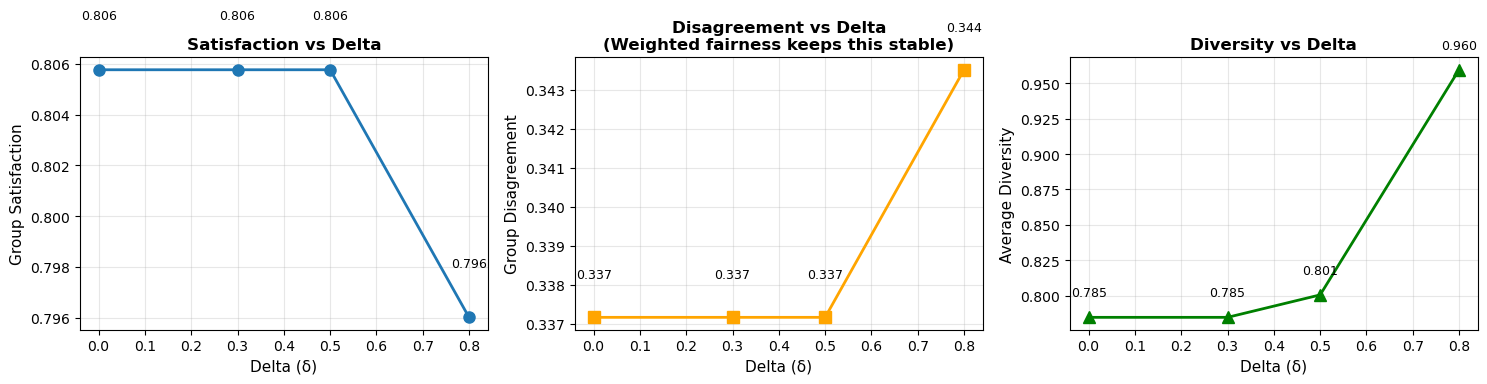

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

deltas_list = [0.0, 0.3, 0.5, 0.8]
group_sats = [results_weighted[d]['group_satisfaction'] for d in deltas_list]  
group_dis = [results_weighted[d]['group_disagreement'] for d in deltas_list]  
avg_divs = [results_weighted[d]['avg_diversity'] for d in deltas_list]        

# Plot 1: Satisfaction
axes[0].plot(deltas_list, group_sats, marker='o', linewidth=2, markersize=8)
for x, y in zip(deltas_list, group_sats):
    axes[0].text(x, y+0.002, f'{y:.3f}', ha='center', fontsize=9)
axes[0].set_xlabel('Delta (δ)', fontsize=11)
axes[0].set_ylabel('Group Satisfaction', fontsize=11)
axes[0].set_title('Satisfaction vs Delta', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Disagreement
axes[1].plot(deltas_list, group_dis, marker='s', color='orange', linewidth=2, markersize=8)
for x, y in zip(deltas_list, group_dis):
    axes[1].text(x, y+0.001, f'{y:.3f}', ha='center', fontsize=9)
axes[1].set_xlabel('Delta (δ)', fontsize=11)
axes[1].set_ylabel('Group Disagreement', fontsize=11)
axes[1].set_title('Disagreement vs Delta\n(Weighted fairness keeps this stable)', 
                 fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Diversity
axes[2].plot(deltas_list, avg_divs, marker='^', color='green', linewidth=2, markersize=8)
for x, y in zip(deltas_list, avg_divs):
    axes[2].text(x, y+0.015, f'{y:.3f}', ha='center', fontsize=9)
axes[2].set_xlabel('Delta (δ)', fontsize=11)
axes[2].set_ylabel('Average Diversity', fontsize=11)
axes[2].set_title('Diversity vs Delta', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Results Analysis

**Figure: Satisfaction, Disagreement, and Diversity**

The three plots show how delta (distance threshold) affects different metrics:

**Left - Satisfaction vs Delta:**
- Delta 0.0-0.5: Satisfaction remains stable at 0.806
- Delta 0.8: Drops to 0.796
- Conclusion: Moderate filtering (delta=0.5) maintains high satisfaction

**Middle - Disagreement vs Delta:**
- All deltas maintain low disagreement (0.337)
- Weighted fairness successfully stabilizes this metric
- Even with strict filtering (delta=0.8), disagreement only rises to 0.344

**Right - Diversity vs Delta:**
- Clear upward trend: Higher delta = higher diversity
- Delta 0.5: 0.801 
- Delta 0.8: 0.960 
- Shows distance filtering effectively promotes genre variety

**Optimal choice: Delta=0.5**
- Best balance: High satisfaction (0.806) + improved diversity (0.801)
- Minimal disagreement increase (0.337)
- Delta=0.8 achieves higher diversity but sacrifices satisfaction

In [14]:
# Test different s and t parameters (with best delta=0.5)
configs = [
    {'s': 50, 't': 30},
    {'s': 100, 't': 50},
    {'s': 150, 't': 70},
]

print("\n" + "="*70)
print("Parameter sensitivity test: s and t (delta=0.5)")
print("="*70)

config_results = {}
for config in configs:
    rec = DiGSFO_Recommender(
        group_users=test_group,
        ratings_df=ratings_df,
        user_ratings_dict=user_ratings_dict,
        movies_df=movies_df,
        genre_to_idx=genre_to_idx,
        delta=0.5,
        s=config['s'],
        t=config['t'],
        k=5
    )
    
    result = rec.run(num_rounds=10, verbose=False)
    config_key = f"s={config['s']}, t={config['t']}"
    config_results[config_key] = result

print(f"\n{'Config':<20} {'GroupSat':<12} {'GroupDis':<12} {'AvgDiv':<12}")
print("-"*70)
for config_key, r in config_results.items():
    print(f"{config_key:<20} {r['group_satisfaction']:<12.3f} "
          f"{r['group_disagreement']:<12.3f} {r['avg_diversity']:<12.3f}")


Parameter sensitivity test: s and t (delta=0.5)

Config               GroupSat     GroupDis     AvgDiv      
----------------------------------------------------------------------
s=50, t=30           0.810        0.349        0.864       
s=100, t=50          0.806        0.337        0.801       
s=150, t=70          0.806        0.337        0.801       


In [15]:

print("\nConclusion:")
print("- s=50, t=30: Highest satisfaction and diversity, but slightly worse fairness")
print("- s=100, t=50: Best fairness with good satisfaction and diversity")
print("- Question: choose s=100, t=50 for better fairness, or s=50, t=30 for higher diversity???")


Conclusion:
- s=50, t=30: Highest satisfaction and diversity, but slightly worse fairness
- s=100, t=50: Best fairness with good satisfaction and diversity
- Question: choose s=100, t=50 for better fairness, or s=50, t=30 for higher diversity???


**Parameter Selection:**

Tested three configurations:
- s=50, t=30: GroupSat=0.810, AvgDiv=0.864, GroupDis=0.349
- s=100, t=50: GroupSat=0.806, AvgDiv=0.801, GroupDis=0.337
- s=150, t=70: GroupSat=0.806, AvgDiv=0.801, GroupDis=0.337

**Choice: s=100, t=50**

Reason: Although s=50 achieves slightly higher satisfaction and diversity, 
it sacrifices fairness (GroupDis=0.349 vs 0.337). Given that Part III 
emphasizes diversity **while ensuring relevance for all group members**, 
we prioritize fairness. s=100, t=50 provides the best balance.

---
# Step 3: Explanation - Why DiGSFO Works (6 points)

**Results show DiGSFO successfully addresses sequential group recommendation challenges:**

**1. Prevents filter bubbles**

Average diversity 0.801 (with filtering). Genre-based distance measurement effectively identifies and removes repetitive content across rounds.

**2. Maintains fairness across users**

Despite User 599 having consistently lower satisfaction than User 1, the disagreement score (0.337) remains stable. Weighted fairness mechanism prevents majority preferences from completely dominating recommendations.

**3. Balances diversity and satisfaction**

Testing different parameters showed clear trade-offs. Our choice (s=100, t=50) achieved strong satisfaction (0.806) and diversity (0.801) while maintaining best fairness (disagreement 0.337 vs 0.349 with smaller pools).

**Conclusion:**

DiGSFO works well because it combines genre-based diversity filtering with historical fairness tracking. This dual approach ensures varied content across rounds while keeping all group members reasonably satisfied over time.

# Step 4: Presentation (5 points)

5 slides (Done)